# 代码实现

接下来，我们将动手编写实现基于视觉词袋模型的图像分类算法。我们先导入必要的库，并导入Caltech-101数据集。

In [9]:
from PIL import Image
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.kernel_approximation import AdditiveChi2Sampler
import random
import math
from imutils import paths

In [10]:
# 图像数据
data = []
# 图像对应的标签
labels = []
# 储存标签信息的临时变量
labels_tep = []
# 数据集的地址
# 请读者自行下载数据集，并将数据集放在代码的同级目录下
image_paths = list(paths.list_images('./caltech-101'))

for image_path in image_paths:
    # 获取图像类别
    label = image_path.split(os.path.sep)[-2]
    # 读取每个类别的图像
    image = cv2.imread(image_path)
    # 将图像通道从BGR转换为RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 统一输入图像的尺寸
    image = cv2.resize(image, (200,200), interpolation=cv2.INTER_AREA)
    data.append(image)
    labels_tep.append(label)

name2label = {}
tep = {}
for idx, name in enumerate(labels_tep):
    tep[name] = idx
for idx, name in enumerate(tep):
    name2label[name] = idx
for idx, image_path in enumerate(image_paths):
    labels.append(name2label[image_path.split(os.path.sep)[-2]])

data = np.array(data)
labels = np.array(labels)

我们接着对数据集进行训练集验证集和测试集的划分。

In [11]:
(x_train, X, y_train, Y) = train_test_split(data, labels, 
        test_size=0.4, stratify=labels, random_state=42)
(x_val, x_test, y_val, y_test) = train_test_split(X, Y, 
        test_size=0.5, random_state=42)
print(f"x_train examples: {x_train.shape}\n\
      x_test examples: {x_test.shape}\n\
        x_val examples: {x_val.shape}")

x_train examples: (5486, 200, 200, 3)
      x_test examples: (1829, 200, 200, 3)
        x_val examples: (1829, 200, 200, 3)


我们先进行视觉词典的构建。为了得到视觉词典，首先需要对输入图像的表征进行提取，这里使用SIFT对图像进行处理。

In [5]:
# 构建一个词典，储存每一个类别的sift信息
vec_dict = {i:{'kp':[], 'des':{}} for i in range(102)}

sift = cv2.SIFT_create()
for i in range(x_train.shape[0]):
    # 对图像正则化
    tep = cv2.normalize(x_train[i], None, 0, 255, 
                        cv2.NORM_MINMAX).astype('uint8')
    # 计算图像的SIFT特征
    kp_vector, des_vector = sift.detectAndCompute(tep, None)
    # 特征点和描述符信息储存进词典中
    vec_dict[y_train[i]]['kp'] += list(kp_vector)
    for k in range(len(kp_vector)):
        # des使用kp_vector将其一一对应
        vec_dict[y_train[i]]['des'][kp_vector[k]] = des_vector[k]

接着，为了保持类别之间的平衡，为每个类别选取相同个数的特征用于之后的聚类。先统计每个类别的SIFT图像特征个数，找到拥有最少特征个数的类别，然后以该类别的特征个数为标准个数，从每个类别的特征中筛选出标准个数的特征进行后续的聚类任务。

In [6]:
# 设置最少特征点的数目
bneck_value = float("inf")

# 确定bneck_value的数值
for i in range(102):
    if len(vec_dict[i]['kp']) < bneck_value:
        bneck_value = len(vec_dict[i]['kp'])

# 按照每一个SIFT特征点的响应值对特征进行降序排序
for i in range(102):
    kp_list = vec_dict[i]['kp'] = sorted((vec_dict[i]['kp']), 
                                         key=lambda x: x.response, 
                                         reverse=True)
    
    
        
# 为每个类别选择同样多的特征点用于聚类。特征点个数bneck_value
vec_list=[]
for i in range(bneck_value):
    vec_list.append(vec_dict[0]['des'][vec_dict[0]['kp'][i]])

for i in range(1, 102):
    for j in range(bneck_value):
        vec_list.append(vec_dict[i]['des'][vec_dict[i]['kp'][j]])

vec_list = np.float64(vec_list)


然后，使用$k$-means聚类算法将这些特征进行聚类，得到的聚类中心组成视觉词典。这里，将聚类中心个数设置为200。

In [7]:
from sklearn.cluster import KMeans
N_clusters = 200
kmeans = KMeans(n_clusters=N_clusters, random_state=0).fit(vec_list)

我们引入空间金字塔匹配算法提升词袋模型的表征能力。


In [8]:
def extract_SIFT(img):
    sift = cv2.SIFT_create()
    descriptors = []
    for disft_step_size in DSIFT_STEP_SIZE:
        keypoints = [cv2.KeyPoint(x, y, disft_step_size)
                for y in range(0, img.shape[0], disft_step_size)
                    for x in range(0, img.shape[1], disft_step_size)]

        descriptors.append(sift.compute(img, keypoints)[1])
    
    return np.concatenate(descriptors, axis=0).astype('float64')


# 获取图像的SPM特征
def getImageFeaturesSPM(L, img, kmeans, k):
    W = img.shape[1]
    H = img.shape[0]   
    h = []
    for l in range(L+1):
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for _ in range(2**l):
            x = 0
            for __ in range(2**l):
                desc = extract_SIFT(img[y:y+h_step, x:x+w_step])                
                predict = kmeans.predict(desc)
                histo = np.bincount(predict, 
                        minlength=k).reshape(1,-1).ravel()
                weight = 2**(l-L)
                h.append(weight*histo)
                x = x + w_step
            y = y + h_step
            
    hist = np.array(h).ravel()
    hist /= np.sum(hist)
    return hist


分别使用SPM提取训练集和测试集图像的特征。

In [9]:
# SPM 的一些超参数
pyramid_level = 2
DSIFT_STEP_SIZE = [4, 8]

hist_vector = []
for i in range(x_train.shape[0]):
    tep = cv2.normalize(x_train[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # 提取图像的SPM特征
    hist_SPM = getImageFeaturesSPM(pyramid_level, tep, kmeans, N_clusters)
    # 将提取的特征加入直方图中
    hist_vector.append(hist_SPM)
hist_vector = np.array(hist_vector)


In [10]:
hist_test_vector = []
for i in range(x_test.shape[0]):
    tep = cv2.normalize(x_test[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    hist_SPM = getImageFeaturesSPM(pyramid_level, tep, kmeans, N_clusters)
    hist_test_vector.append(hist_SPM)
hist_test_vector = np.array(hist_test_vector)


最后，训练一个SVM分类器，进行图像分类。

In [11]:
from sklearn import svm

# transform使用一种特征映射的方法
transformer = AdditiveChi2Sampler()
transformer = transformer.fit(np.concatenate(
    [hist_vector, hist_test_vector], axis=0)
                             )

# 构建SVM分类器
classifier = svm.LinearSVC()
# 将训练的直方图进行特征映射
hist_vector = transformer.transform(hist_vector)

# 对数据进行拟合
classifier.fit(hist_vector, y_train)


LinearSVC()

最后，在测试集上对分类器进行评估，并计算 top-1 错误率。

In [ ]:
# 将测试的直方图进行特征映射
hist_test_vector = transformer.transform(hist_test_vector)

# 计算分类 top-1 错误率
top1_error = classifier.predict(hist_test_vector) - y_test
tep = len(top1_error[top1_error!=0])
print('top-1 error: ', tep/len(y_test))

top-1 error:  0.3001640240568617


为了更深入的了解ResNet，我们先动手编写ResNet34网络。


In [12]:
import torch as t
from torch import nn
from torch.nn import functional as F

# 残差结构
class ResidualBlock(nn.Module):
    
    # 深度学习中的图像和利用模型提取的特征图往往有很多通道（channel）
    # 比如RGB图像的通道为3，即R通道、B通道与G通道
    def __init__(self, inchannel, outchannel, stride=1, shortcut=None):
        super(ResidualBlock, self).__init__()
        # 观察图 10-6，不难发现残差结构可大致分为左右两部分
        # 左边是一系列的网络层级，右边是一个跳跃连接
        # 定义左边
        self.left = nn.Sequential(
            # 对应图 10-6 中第一个权重层
            nn.Conv2d(inchannel, outchannel, 3, stride, 1, bias=False),
            nn.BatchNorm2d(outchannel),
            
            # 对应图 10-6 中的 RELU
            nn.ReLU(inplace=True),
            
            # 对应图 10-6 中第二个权重层
            nn.Conv2d(outchannel, outchannel, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outchannel))
        
        # 定义右边
        self.right = shortcut
        
    # forward()函数在网络结构中起到举足轻重的作用，它决定着网络如何对数据进行传播
    def forward(self, x):
        out = self.left(x)
        # 构建残差结构
        residual = x if self.right is None else self.right(x)
        out += residual
        
        return F.relu(out)


# 在这一模块中，将实现 ResNet34，其对应的结构可查看图 10-7
class ResNet(nn.Module):
    def __init__(self, num_classes=102):
        super(ResNet, self).__init__()
        # 前几层图像转换
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
        )

        # 重复的网络层分别有3、4、6、3个残差块
        self.layer1 = self._make_layer(64, 128, 3)
        self.layer2 = self._make_layer(128, 256, 4, stride=2)
        self.layer3 = self._make_layer(256, 512, 6, stride=2)
        self.layer4 = self._make_layer(512, 512, 3, stride=2)

        # 分类用的全连接层，将一个多通道的特征图映射到一个维度为类别数目的向量
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        # 定义shortcut连接
        shortcut = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, 1, stride, bias=False),
            nn.BatchNorm2d(outchannel))

        layers = []
        
        # 给当前网络层级添加残差块
        layers.append(ResidualBlock(inchannel, outchannel, 
                                    stride, shortcut))

        for i in range(1, block_num):
            layers.append(ResidualBlock(outchannel, outchannel))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.pre(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x, 7)
        x = x.view(x.size(0), -1)

        return self.fc(x)

可以使用nn.Covn2d()函数实现卷积操作，该函数定义如下：

In [ ]:
nn.Conv2d(in_channels,          # 输入的通道数
          out_channels,         # 输出的通道数
          kernel_size,          # 卷积核的大小
          stride=1,             # 卷积核移动的步长
          padding=0,            # 卷积核补零的层数
          )

接下来，我们将动手编写完成基于Resnet34的图像分类任务。首先，先导入必要的库。

In [13]:
import torch.optim as optim
import torch
import torch.optim
import torch.utils.data as Data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

我们对数据进行增强。

In [14]:
# 定义训练图像增强（变换）的方法
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     # transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                          std=[0.229, 0.224, 0.225])])

# 定义训练图像增强（变换）的方法
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     # transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                          std=[0.229, 0.224, 0.225])])

接着，把Caltech-101数据集封装成类，并生成训练集类、验证集类以及测试集类。

In [15]:
# 数据集
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms

    def __len__(self):
        return (len(self.X))
    
    # 用于深度学习训练构建的数据类中，__getitem__()函数非常重要
    # __getitem__()决定着数据如何传入模型
    # 在下面的代码中，可以发现，当transforms非空时:
    # 数据将先经过transforms进行数据增强，再返回进行后续操作
    def __getitem__(self, i):
        data = self.X[i][:]

        if self.transforms:
            data = self.transforms(data)

        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

# 生成不同的类用于训练、验证以及测试
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

In [16]:
BATCH_SIZE = 2048

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

接下来，我们开始加载ResNet34模型。这里将直接调用已经封装好的库。

In [ ]:
# 根据当前设备选择使用CPU或者GPU训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 加载ImageNet预训练的模型
model = torchvision.models.resnet34(pretrained='imagenet')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model.to(device)

# 多张GPU并行训练
model = nn.DataParallel(model)


继续定义训练时需要用到的优化器和损失函数：

In [18]:
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# 定义损失函数
criterion = nn.CrossEntropyLoss()

接下来，编写训练模型、验证模型以及测试模型top-1错误率的函数。

In [ ]:
# 定义训练函数
def fit(model, dataloader):

    model.train()
    
    # 初始化模型损失以及模型 top-1 错误率
    running_loss = 0.0
    running_top1_error = 0
    
    # 开始迭代
    for i, data in enumerate(dataloader):
        
        # 准备好训练的图像和标签，每次传入的数据量为batch_size
        x, y = data[0].to(device), data[1].to(device)
        # 需要在开始进行反向传播之前将梯度设置为零
        # 因为PyTorch会在随后的反向传递中累积梯度
        optimizer.zero_grad()
        
        # 将数据传入模型中，获得输出的预测标签
        outputs = model(x)
        
        # 将预测标签与真实标签计算损失
        loss = criterion(outputs, y)
        
        # 记录当前损失
        running_loss += loss.item()
        
        # 记录当前 top-1 错误率
        _, preds = torch.max(outputs.data, 1)
        running_top1_error += torch.sum(preds != y)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        

    loss = running_loss / len(dataloader.dataset)
    top1_error = running_top1_error / len(dataloader.dataset)

    print(f"Train Loss: {loss:.4f}, Train Top-1 Error: {top1_error:.4f}")

    return loss, top1_error

In [ ]:
# 定义验证函数，可以通过验证集对模型的参数进行调整
def validate(model, dataloader):

    model.eval()
    
    # 初始化模型损失以及模型 top-1 错误率
    running_loss = 0.0
    running_top1_error = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # 流程同训练
            x, y = data[0].to(device), data[1].to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_top1_error += torch.sum(preds != y)
            
        loss = running_loss / len(dataloader.dataset)
        top1_error = running_top1_error / len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Top-1 Error: {top1_error:.4f}')

        return loss, top1_error

In [ ]:
# 定义测试函数，评估模型的效果
def test(model, dataloader):
    error = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            x, y = data[0].to(device), data[1].to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            error += torch.sum(predicted != y)
    return error, total



开始训练模型。

In [22]:
# 开始对模型进行训练

# 设定迭代的轮次
epochs = 25
# 设定训练以及验证的损失与 top-1 错误率
train_loss , train_top1_error = [], []
val_loss , val_top1_error = [], []

print(f"Training on {len(train_data)} examples, \
      validating on {len(val_data)} examples...")

# 开始迭代
for epoch in range(epochs):
    # 输出迭代信息
    print(f"\nEpoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_top1_error = fit(model, trainloader)
    val_epoch_loss, val_epoch_top1_error = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_top1_error.append(train_epoch_top1_error.cpu())
    val_loss.append(val_epoch_loss)
    val_top1_error.append(val_epoch_top1_error.cpu())
    
# 可以保存训练的模型
# torch.save(model.state_dict(), model.pth")


Training on 5486 examples,       validating on 1829 examples...

Epoch 1 of 25
Train Loss: 0.0024, Train Top-1 Error: 0.8977
Val Loss: 0.0019, Val Top-1 Error: 0.6490

Epoch 2 of 25
Train Loss: 0.0017, Train Top-1 Error: 0.5859
Val Loss: 0.0015, Val Top-1 Error: 0.5189

Epoch 3 of 25
Train Loss: 0.0013, Train Top-1 Error: 0.4424
Val Loss: 0.0012, Val Top-1 Error: 0.4117

Epoch 4 of 25
Train Loss: 0.0011, Train Top-1 Error: 0.3208
Val Loss: 0.0010, Val Top-1 Error: 0.3461

Epoch 5 of 25
Train Loss: 0.0009, Train Top-1 Error: 0.2415
Val Loss: 0.0009, Val Top-1 Error: 0.2592

Epoch 6 of 25
Train Loss: 0.0007, Train Top-1 Error: 0.1743
Val Loss: 0.0007, Val Top-1 Error: 0.2056

Epoch 7 of 25
Train Loss: 0.0005, Train Top-1 Error: 0.1185
Val Loss: 0.0006, Val Top-1 Error: 0.1651

Epoch 8 of 25
Train Loss: 0.0004, Train Top-1 Error: 0.0849
Val Loss: 0.0005, Val Top-1 Error: 0.1405

Epoch 9 of 25
Train Loss: 0.0003, Train Top-1 Error: 0.0631
Val Loss: 0.0004, Val Top-1 Error: 0.1241

Epoch 10

绘制并观察 top-1 错误率和损失曲线。

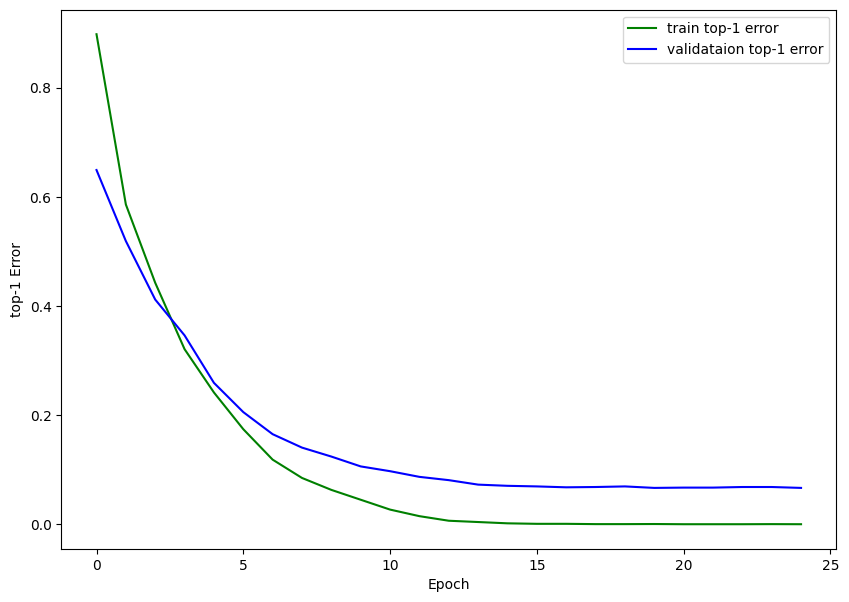

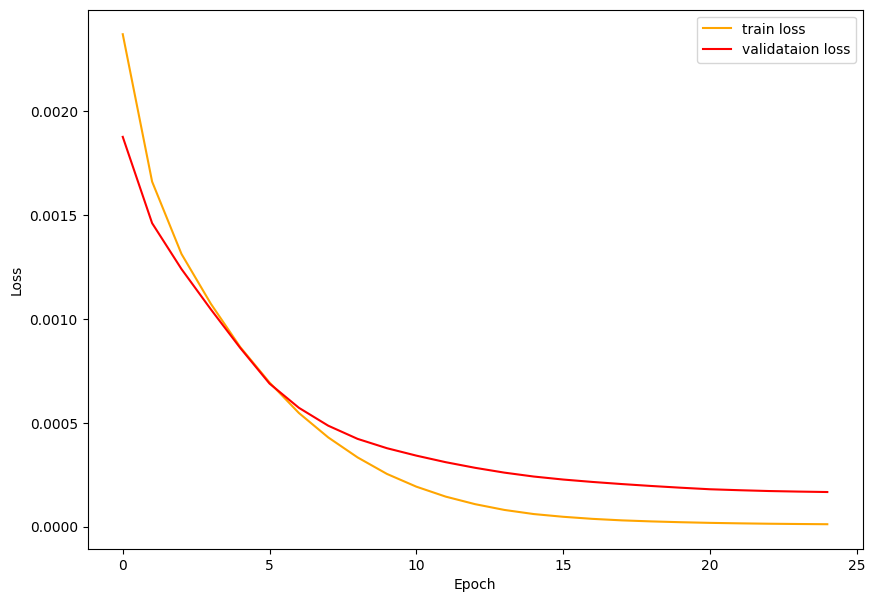

In [ ]:
# 绘制 top-1 错误率曲线
plt.figure(figsize=(10, 7))
# 训练集的top-1 错误率曲线
plt.plot(train_top1_error, color='green', label='train top-1 error')
# 验证集top-1 错误率曲线
plt.plot(val_top1_error, color='blue', label='validataion top-1 error')
plt.xlabel('迭代次数')
plt.ylabel('top-1 错误率')
plt.legend()

# 绘制损失函数曲线
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('迭代次数')
plt.ylabel('损失函数')
plt.legend()



最后，对模型的 top-1 错误率进行评估。

In [ ]:
error, total = test(model, testloader)
print('Top-1 error of the network on test images: %0.3f %%' \
      % (100 * (error / total)))

Top-1 error of the network on test images: 5.358 %
